In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

C:\Users\Philip\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
HIDDEN_SIZE = 30
NUM_LAYERS = 2

TIMESTEPS = 10
TRAINING_STEPS = 3000
BATCH_SIZE = 32

TRAINING_EXAMPLES = 10000
TESTING_EXAMPLES = 1000
SAMPLE_GAP = 0.01              #採樣間隔

In [3]:
def generate_data(seq):
    X = []
    y = []
    
    for i in range(len(seq) - TIMESTEPS):
        #序列的第i項到 i+TIMESTEPS-1項作為輸入，第i+TIMESTEPS項為輸出，即用sin函數前面TIMESTEPS個訊息，預測第i+TIMESTEPS的函數值
        X.append([seq[i: i + TIMESTEPS]])
        y.append([seq[i + TIMESTEPS]])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

test_start = (TRAINING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP
test_end = test_start  + (TESTING_EXAMPLES + TIMESTEPS) * SAMPLE_GAP

#np.linspace可以創建一個等差序列數組
train_X, train_y = generate_data(np.sin(np.linspace(0, test_start, TRAINING_EXAMPLES + TIMESTEPS, dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(test_start, test_end, TESTING_EXAMPLES + TIMESTEPS, dtype=np.float32)))

In [8]:
train_y.shape

(10000, 1)

In [4]:
def lstm_model(X, y, is_training):
    cell = tf.nn.rnn_cell.MultiRNNCell([
        tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE) 
        for _ in range(NUM_LAYERS)]) 
    
    output, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    #因只關注最後一個輸出結果
    output = output[:, -1, :]
    
    predictions = tf.contrib.layers.fully_connected(output, 1, activation_fn=None)
    
    #測試時直接返回預測值
    if not is_training:
        return predictions, None, None
    
    loss = tf.losses.mean_squared_error(labels=y, predictions=predictions)
    
    train_op = tf.contrib.layers.optimize_loss(
    loss, tf.train.get_global_step(),
    optimizer='Adagrad', learning_rate = 0.1)
    
    return predictions, loss, train_op

In [5]:
def run_eval(sess, test_X, test_y):
    # 将测试数据以数据集的方式提供给计算图。
    ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
    ds = ds.batch(1)
    X, y = ds.make_one_shot_iterator().get_next()
    
    # 调用模型得到计算结果。这里不需要输入真实的y值。
    with tf.variable_scope("model", reuse=True):
        prediction, _, _ = lstm_model(X, [0.0], False)
    
    # 将预测结果存入一个数组。
    predictions = []
    labels = []
    for i in range(TESTING_EXAMPLES):
        p, l = sess.run([prediction, y])
        predictions.append(p)
        labels.append(l)

    # 计算rmse作为评价指标。
    predictions = np.array(predictions).squeeze()
    labels = np.array(labels).squeeze()
    rmse = np.sqrt(((predictions - labels) ** 2).mean(axis=0))
    print("Root Mean Square Error is: %f" % rmse)
    
    #对预测的sin函数曲线进行绘图。
    plt.figure()
    plt.plot(predictions, label='predictions')
    plt.plot(labels, label='real_sin')
    plt.legend()
    plt.show()

Evaluate model before training.
Root Mean Square Error is: 0.682325


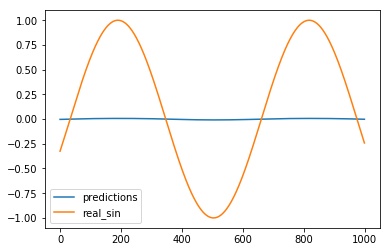

train step: 0, loss: 0.36909193


In [ ]:
# 将训练数据以数据集的方式提供给计算图。
ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
X, y = ds.make_one_shot_iterator().get_next()

# 定义模型，得到预测结果、损失函数，和训练操作。
with tf.variable_scope("model"):
    _, loss, train_op = lstm_model(X, y, True)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # 测试在训练之前的模型效果。
    print ("Evaluate model before training.")
    run_eval(sess, test_X, test_y)
    
    # 训练模型。
    for i in range(TRAINING_STEPS):
        _, l = sess.run([train_op, loss])
        if i % 1000 == 0:
            print("train step: " + str(i) + ", loss: " + str(l))
    
    # 使用训练好的模型对测试数据进行预测。
    print ("Evaluate model after training.")
    run_eval(sess, test_X, test_y)

In [74]:
tf.reset_default_graph()